In [1]:
import pandas as pd
import plotly.express as px
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

from utils import preprocess

In [2]:
df = pd.read_csv("sentiment.csv",encoding = 'latin',header=None)

df.columns = ['targets', 'ids', 'date', 'flag', 'user', 'text']

# Replace all occurrences of 4 with 1 in the "targets" column
df['targets'] = df['targets'].replace(4, 1)

# Check if columns exist before deleting them
columns_to_drop = ['ids', 'date', 'flag', 'user']

for col in columns_to_drop:
    assert col in df.columns, f"La colonne '{col}' n'existe pas dans le DataFrame."

# Delete columns if they exist
df.drop(columns_to_drop, axis=1, inplace=True)

# Display the first rows of the DataFrame

df.head()

,targets,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# Text Preprocessing

We tried to import the preprocess function with: **from utils import preprocess**  
But the execution time is very long when we recall the .apply(preprocess) function

Finally we re-use the function preprocess

In [3]:

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [4]:
print("Text before preprocessing : ", df['text'][0])
df['text'] = df['text'].apply(preprocess)
print("Text after preprocessing : ", df['text'][0])

Text before preprocessing :  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Text after preprocessing :  awww bummer shoulda got david carr third day


# Use Tensorflow (or PyTorch, JAX, ...) and train a sequence model of your choice (RNN, GRU, LSTM, Transformer, ...)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Tokenization

In [6]:
def tokenize_training_data(X_train, max_words = 1000, max_sequence_length = 32):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    sequences = tokenizer.texts_to_sequences(X_train)
    sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    return tokenizer, sequences

In [7]:
# Sample the data
sample_size = 1000  # Adjust the sample size as needed
X_sample = df['text'].sample(n=sample_size, random_state=42)
y_sample = df['targets'].loc[X_sample.index]

# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

nombre_de_1 = y_train.sum()

print("Le nombre de 1 dans l'échantillon de target sur les 1000 premières lignes est :", nombre_de_1)
y_train.sum()



Le nombre de 1 dans l'échantillon de target sur les 1000 premières lignes est : 403


403

In [8]:
# Parameters
max_words = 10000
max_sequence_length = 200

# Tokenize the training & testing data
tokenizer, X_train= tokenize_training_data(X_train, max_words, max_sequence_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_sequence_length)

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, SimpleRNN, Flatten
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns


In [10]:
def evaluate_model(model, X_test, y_test):

    # Make predictions on test data
    prediction_proba = model.predict(X_test)
    prediction = (prediction_proba > 0.5).astype(int)
    # Create a heatmap for the confusion matrix
    conf_matrix = confusion_matrix(y_test, prediction)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# LTSM


We use the LSTM architecture as a baseline.

Epoch 1/10
400/400 [==============================] - 12s 26ms/step - loss: 0.6903 - accuracy: 0.5337
Epoch 2/10
400/400 [==============================] - 11s 27ms/step - loss: 0.4464 - accuracy: 0.8225
Epoch 3/10
400/400 [==============================] - 12s 29ms/step - loss: 0.1129 - accuracy: 0.9688
Epoch 4/10
400/400 [==============================] - 12s 29ms/step - loss: 0.0674 - accuracy: 0.9837
Epoch 5/10
400/400 [==============================] - 12s 30ms/step - loss: 0.0308 - accuracy: 0.9937
Epoch 6/10
400/400 [==============================] - 13s 31ms/step - loss: 0.0132 - accuracy: 0.9950
Epoch 7/10
400/400 [==============================] - 13s 32ms/step - loss: 0.0294 - accuracy: 0.9862
Epoch 8/10
400/400 [==============================] - 13s 32ms/step - loss: 0.0153 - accuracy: 0.9950
Epoch 9/10
400/400 [==============================] - 14s 36ms/step - loss: 0.0079 - accuracy: 0.9975
Epoch 10/10
7/7 [==============================] - 1s 18ms/step


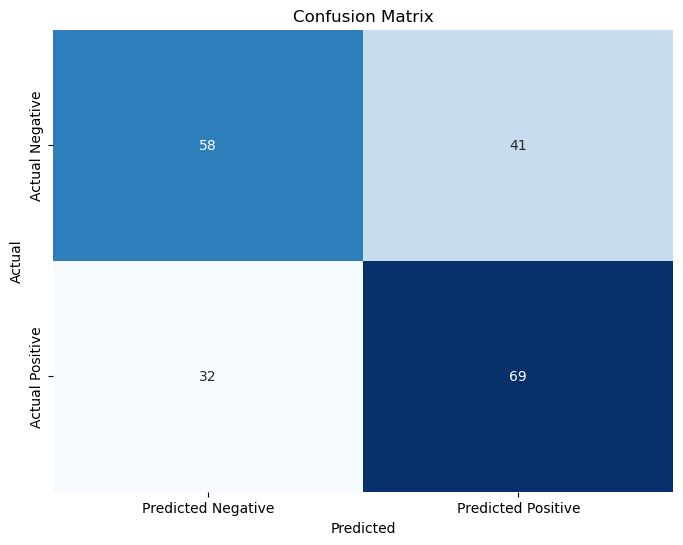

In [11]:
# Parameters
embedding_dim = 32
lstm_units = 32

# Create a Sequential model with LSTM
modelLSTM = keras.Sequential()
modelLSTM.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
modelLSTM.add(LSTM(units=lstm_units))
modelLSTM.add(Dense(1, activation='sigmoid'))

# Compile the model
modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor="loss", patience=3)

# Train the model with early stopping
modelLSTM.fit(X_train, y_train, epochs=10, batch_size=2, callbacks=[early_stopping])

# Evaluation of the modelLSTM on test data
cnn_metrics = evaluate_model(modelLSTM, X_test, y_test)




In [12]:
# Assuming you have the actual y_pred values from your model for X_test
y_pred = modelLSTM.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Display a classification report
classification_rep = classification_report(y_test, y_pred_binary)
print(classification_rep)

7/7 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.64      0.59      0.61        99
           1       0.63      0.68      0.65       101

    accuracy                           0.64       200
   macro avg       0.64      0.63      0.63       200
weighted avg       0.64      0.64      0.63       200



We have a f1-score of 0.61 for the class 0 and 0.65 for the class 1. The model LTSM is less good that our pipeline that we test previously in the TP2